Matched 664 events.
Inference latency (ROI1→ROI2) = 98.0 ± 45.9 ms per 2 frames (batch_size=2)


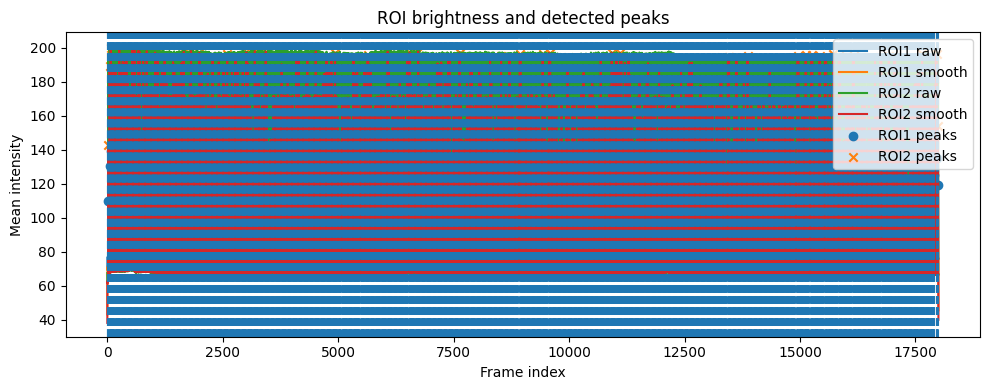

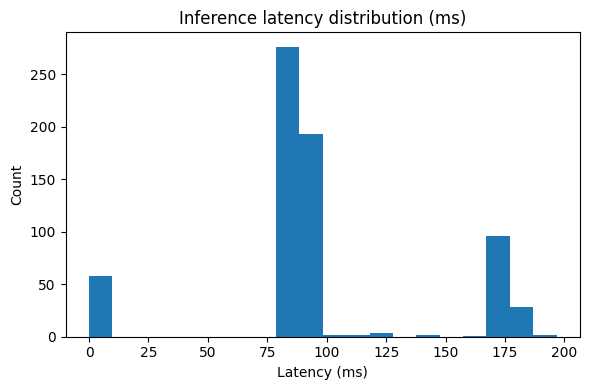

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Try using SciPy peak detection; fall back to a simple implementation if SciPy is unavailable
try:
    from scipy.signal import find_peaks
    _HAS_SCIPY = True
except Exception:
    _HAS_SCIPY = False

def smooth(x, k=5):
    if k <= 1:
        return x
    k = int(k)
    k = max(1, k)
    kernel = np.ones(k, dtype=float) / k
    return np.convolve(x, kernel, mode='same')

def find_peaks_fallback(sig, distance=3, prominence=10):
    """Very simple fallback peak detector (used when SciPy is unavailable)."""
    x = sig
    # Coarse threshold: mean + 1.5 * std
    thr = x.mean() + 1.5 * x.std()
    # Local maxima by zero-crossing of first derivative
    dx = np.diff(x)
    cand = np.where((np.hstack([dx, 0]) <= 0) & (np.hstack([0, dx]) > 0) & (x > thr))[0]
    # Simple minimum spacing filtering
    if len(cand) == 0:
        return np.array([], dtype=int)
    keep = [cand[0]]
    for i in cand[1:]:
        if i - keep[-1] >= distance:
            keep.append(i)
    return np.array(keep, dtype=int)

def extract_roi_mean(frame_gray, roi):
    x, y, w, h = roi
    x2, y2 = x + w, y + h
    patch = frame_gray[y:y2, x:x2]
    if patch.size == 0:
        return np.nan
    return float(patch.mean())

def load_video_signals(video_path, ts_path, roi1, roi2, max_frames=None, smooth_win=5):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Cannot open video: {video_path}")

    # Load timestamps from .npy
    ts = np.load(ts_path)

    if ts.ndim == 1:
        # 1D: treat directly as relative seconds
        t_rel = ts.astype(float)
    elif ts.ndim == 2:
        # 2D: use first column as relative seconds
        t_rel = ts[:, 0].astype(float)
    else:
        raise ValueError(f"Unexpected timestamp array shape: {ts.shape}")

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) or len(t_rel)
    n = min(total_frames, len(t_rel))
    if max_frames is not None:
        n = min(n, int(max_frames))

    s1 = np.zeros(n, dtype=float)
    s2 = np.zeros(n, dtype=float)

    i = 0
    while i < n:
        ok, frame = cap.read()
        if not ok:
            # Stop when frame cannot be read
            s1 = s1[:i]
            s2 = s2[:i]
            t_rel = t_rel[:i]
            break
        if frame.ndim == 3:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        else:
            gray = frame

        s1[i] = extract_roi_mean(gray, roi1)
        s2[i] = extract_roi_mean(gray, roi2)
        i += 1

    cap.release()

    # Simple smoothing to assist peak detection
    s1s = smooth(s1, smooth_win)
    s2s = smooth(s2, smooth_win)
    return (s1, s2, s1s, s2s, t_rel)

def detect_peaks(sig, min_distance_frames=3, prominence=10):
    if _HAS_SCIPY:
        peaks, _ = find_peaks(sig, distance=max(1, int(min_distance_frames)), prominence=prominence)
        return peaks
    else:
        return find_peaks_fallback(sig, distance=max(1, int(min_distance_frames)), prominence=prominence)

def match_peaks_forward(t_rel, peaks_a, peaks_b, max_match_ms=200):
    """
    Match each peak in A to the nearest later peak in B (forward-only).
    Accept only if time difference <= max_match_ms.
    Returns: list of (idx_a, idx_b) and corresponding delays (ms).
    """
    if len(peaks_a) == 0 or len(peaks_b) == 0:
        return [], np.array([])

    tA = t_rel[peaks_a]
    tB = t_rel[peaks_b]
    j = 0
    pairs = []
    delays_ms = []

    for i, ta in enumerate(tA):
        # Move j until tB[j] >= ta
        while j < len(tB) and tB[j] < ta:
            j += 1
        if j >= len(tB):
            break
        # Candidate match
        dt = (tB[j] - ta) * 1000.0
        if 0 <= dt <= max_match_ms:
            pairs.append((peaks_a[i], peaks_b[j]))
            delays_ms.append(dt)
            j += 1  # Do not reuse the same peak in B
    return pairs, np.array(delays_ms)

# ===================== User Section: Fill paths and ROI settings =====================
video_path = "camera_output_20250813.mp4"      # Your behavioral video
ts_path    = "timestamps_20250813.npy"         # Saved timestamps (N,2): [t_rel_s, t_unix_s]
roi1 = (169, 231, 211-169, 266-631)            # ROI for LED1 (acquisition done/frame arrival): (x, y, w, h)
roi2 = (173, 371, 216-173, 408-371)            # ROI for LED2 (inference done): (x, y, w, h)

# Peak detection and matching parameters (adjustable)
smooth_win = 5               # Smoothing window size (in frames)
min_dist_frames = 3          # Minimum frame spacing between peaks
prominence_value = 10        # Peak prominence threshold (higher = more strict)
max_match_ms = 200           # Max allowed A→B delay (milliseconds)

# ===================== Run Analysis =====================
s1, s2, s1s, s2s, t_rel = load_video_signals(
    video_path, ts_path, roi1, roi2, smooth_win=smooth_win
)

# Peak detection (on smoothed signals)
peaks1 = detect_peaks(s1s, min_distance_frames=min_dist_frames, prominence=prominence_value)
peaks2 = detect_peaks(s2s, min_distance_frames=min_dist_frames, prominence=prominence_value)

pairs, delays_ms = match_peaks_forward(t_rel, peaks1, peaks2, max_match_ms=max_match_ms)

# Result statistics
if delays_ms.size > 0:
    mean_ms = delays_ms.mean()
    std_ms  = delays_ms.std(ddof=1) if delays_ms.size > 1 else 0.0
    print(f"Matched {len(delays_ms)} events.")
    print(f"Inference latency (ROI1→ROI2) = {mean_ms:.1f} ± {std_ms:.1f} ms per 2 frames (batch_size=2)")
else:
    print("No matched events under current thresholds. Try relaxing 'prominence_value' or increasing 'max_match_ms'.")

# ===================== Visualization =====================
# 1) Brightness signals and peak positions (frame index on x-axis)
plt.figure(figsize=(10,4))
plt.plot(s1, label='ROI1 raw')
plt.plot(s1s, label='ROI1 smooth')
plt.plot(s2, label='ROI2 raw')
plt.plot(s2s, label='ROI2 smooth')
plt.scatter(peaks1, s1s[peaks1], marker='o', label='ROI1 peaks')
plt.scatter(peaks2, s2s[peaks2], marker='x', label='ROI2 peaks')
for a, b in pairs:
    plt.axvline(a, linestyle='--')
    plt.axvline(b, linestyle='--')
plt.title("ROI brightness and detected peaks")
plt.xlabel("Frame index")
plt.ylabel("Mean intensity")
plt.legend()
plt.tight_layout()
plt.show()

# 2) Latency histogram
if delays_ms.size > 0:
    plt.figure(figsize=(6,4))
    plt.hist(delays_ms, bins=20)
    plt.title("Inference latency distribution (ms)")
    plt.xlabel("Latency (ms)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
